# August 2025 TripleTen Code Pudding

## Team 2 

We've been tasked with training a neural network on Spotify data to try to predict its popularity rating.

In [1]:
# basics
import pandas as pd
import numpy as np

# EDA

import matplotlib.pyplot as plt

# torch for neural network
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# sklearn for preprocessing and sanity-check model
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [2]:
df = pd.read_csv('data/SpotifyFeatures.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232725 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             232725 non-null  object 
 1   artist_name       232725 non-null  object 
 2   track_name        232724 non-null  object 
 3   track_id          232725 non-null  object 
 4   popularity        232725 non-null  int64  
 5   acousticness      232725 non-null  float64
 6   danceability      232725 non-null  float64
 7   duration_ms       232725 non-null  int64  
 8   energy            232725 non-null  float64
 9   instrumentalness  232725 non-null  float64
 10  key               232725 non-null  object 
 11  liveness          232725 non-null  float64
 12  loudness          232725 non-null  float64
 13  mode              232725 non-null  object 
 14  speechiness       232725 non-null  float64
 15  tempo             232725 non-null  float64
 16  time_signature    23

In [4]:
df.head(5)

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Movie,Henri Salvador,C'est beau de faire un Show,0BRjO6ga9RKCKjfDqeFgWV,0,0.611,0.389,99373,0.910,0.000,C#,0.3460,-1.828,Major,0.0525,166.969,4/4,0.814
1,Movie,Martin & les fées,Perdu d'avance (par Gad Elmaleh),0BjC1NfoEOOusryehmNudP,1,0.246,0.590,137373,0.737,0.000,F#,0.1510,-5.559,Minor,0.0868,174.003,4/4,0.816
2,Movie,Joseph Williams,Don't Let Me Be Lonely Tonight,0CoSDzoNIKCRs124s9uTVy,3,0.952,0.663,170267,0.131,0.000,C,0.1030,-13.879,Minor,0.0362,99.488,5/4,0.368
3,Movie,Henri Salvador,Dis-moi Monsieur Gordon Cooper,0Gc6TVm52BwZD07Ki6tIvf,0,0.703,0.240,152427,0.326,0.000,C#,0.0985,-12.178,Major,0.0395,171.758,4/4,0.227
4,Movie,Fabien Nataf,Ouverture,0IuslXpMROHdEPvSl1fTQK,4,0.950,0.331,82625,0.225,0.123,F,0.2020,-21.150,Major,0.0456,140.576,4/4,0.390


# Preprocessing

Checking for missing/duplicate values.

In [5]:
df['track_id'].duplicated().value_counts()

track_id
False    176774
True      55951
Name: count, dtype: int64

In [6]:
df_duplicates = df[df['track_id'].duplicated() == True].index
df.drop(df_duplicates, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176774 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             176774 non-null  object 
 1   artist_name       176774 non-null  object 
 2   track_name        176773 non-null  object 
 3   track_id          176774 non-null  object 
 4   popularity        176774 non-null  int64  
 5   acousticness      176774 non-null  float64
 6   danceability      176774 non-null  float64
 7   duration_ms       176774 non-null  int64  
 8   energy            176774 non-null  float64
 9   instrumentalness  176774 non-null  float64
 10  key               176774 non-null  object 
 11  liveness          176774 non-null  float64
 12  loudness          176774 non-null  float64
 13  mode              176774 non-null  object 
 14  speechiness       176774 non-null  float64
 15  tempo             176774 non-null  float64
 16  time_signature    176774 

We know there's a missing track name, so let's look into that.

In [7]:
df['track_name'].isna().value_counts()

track_name
False    176773
True          1
Name: count, dtype: int64

In [8]:
df[df['track_name'].isna() == True]

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
208285,World,Elevation Worship,NaN,7BGQCe62A58Q5ZgpQFX93t,44,0.019,0.287,350027,0.446,0.0,F,0.1,-7.214,Major,0.0317,138.727,4/4,0.0387


Presumably the track name is not literally "NaN." A correlation between track name and popularity doesn't make much sense (maybe very long names are unmarketable and less popular for that reason?), so let's not worry about it.

# Investigation and EDA

So what's in this dataset, anyway?

In [9]:
df['genre'].value_counts()

genre
Comedy              9674
Electronic          9149
Alternative         9095
Anime               8935
Classical           8711
Reggae              8687
Reggaeton           8549
Blues               8496
Soundtrack          8480
Opera               8280
Folk                8048
Jazz                8039
Ska                 8017
Dance               7982
World               7973
Movie               7802
Hip-Hop             7413
Country             7383
Children's Music    5402
R&B                 5353
Soul                4430
Indie               3318
Pop                 2417
Rock                2227
Rap                 1456
Children’s Music    1339
A Capella            119
Name: count, dtype: int64

The project is specifically about "song" popularity. It's unclear that the data for "Movie" tracks counts, as those might be full-on movies (presumably soundtracks would be under "Soundtrack" instead). Let's leave it be for now.

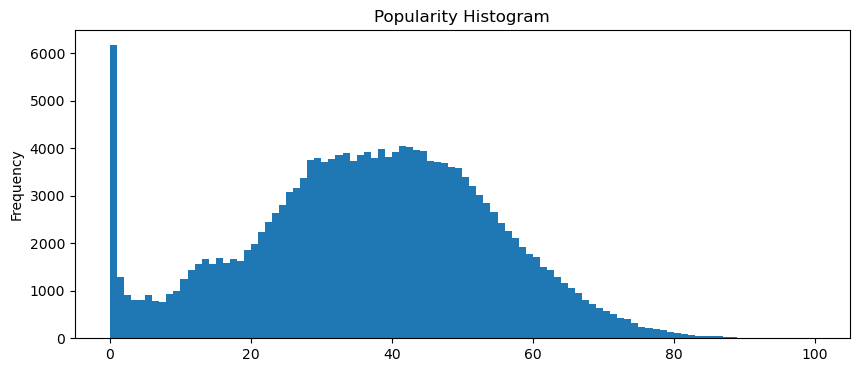

In [10]:
df['popularity'].plot(title='Popularity Histogram', kind='hist', bins=100, figsize=(10, 4))
plt.show()

There are a lot of songs with 0-ish popularity. Going by the histogram, you'd expect at most 1500ish, but there are over 6000! Zero popularity is apparently the most common. Is this evidence of missing data?

In [11]:
df[df['popularity'] == 0]['genre'].value_counts()

genre
Children's Music    2966
Movie               1733
Classical            892
Dance                109
Opera                 92
Country               63
Jazz                  60
Blues                 55
Electronic            53
Reggae                44
Anime                 36
Soul                  16
A Capella             10
Children’s Music       9
Comedy                 8
Alternative            7
R&B                    6
Folk                   6
Soundtrack             3
Reggaeton              1
Rock                   1
Name: count, dtype: int64

These entries are highly concentrated in three genres: children's music, "movie", and classical music. What genres appear most on the highly-populated end?

In [12]:
df[df['popularity'] > 80]['genre'].value_counts()

genre
Dance               146
Hip-Hop             116
Pop                 107
Rap                  62
Reggaeton            25
Rock                 17
Folk                  4
Indie                 4
Children’s Music      3
Alternative           2
Soul                  2
Electronic            1
Movie                 1
Country               1
Name: count, dtype: int64

Looks like pop, rap, dance, and hip-hop are popular with Spotify users, or at least in this subset of tracks. 

Spotify's API documentation has this to say about popularity:

> The popularity of the track. The value will be between 0 and 100, with 100 being the most popular.
The popularity of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are.
Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past. Duplicate tracks (e.g. the same track from a single and an album) are rated independently. Artist and album popularity is derived mathematically from track popularity. Note: the popularity value may lag actual popularity by a few days: the value is not updated in real time.

It stands to reason that there are likely many tracks on Spotify that don't get played often. Without further transparency about how their algorithm works, there's no particular reason to believe the outlier is indicative of missing data, aside from being an outlier itself. So we'll leave it untouched.

In [13]:
df[['key', 'mode']].value_counts()

key  mode 
C    Major    16740
G    Major    15625
D    Major    14249
C#   Major    11939
A    Major    10718
F    Major     9365
G#   Major     8449
B    Minor     6867
E    Major     6791
A    Minor     6781
E    Minor     6617
A#   Major     6434
F    Minor     6240
F#   Major     6132
B    Major     6026
A#   Minor     5490
F#   Minor     5233
C#   Minor     4917
G    Minor     4851
D    Minor     4394
C    Minor     4230
D#   Major     4151
G#   Minor     2726
D#   Minor     1809
Name: count, dtype: int64

It strikes me as unlikely that musical key correlates to popularity (and it's likely ambiguous for some kinds of music anyway). But it is interesting to see how lopsided the representation is among Spotify's data. Our top 7 keys are all major keys, for starters.

C major being common is unsurprising. It's the simplest major key from a theory perspective: no sharps, no flats. This would make it a very reasonable default to write in for keyboard-based instruments like pianos and synthesizers. 

G, D, and A make a lot of sense through the lens of guitar, which is also a very common instrument in popular genres.

Three typical beginner guitar chords are G-C-D, corresponding to I-IV-V in G major. A guitarist that also knows the A major chord can then play D-G-A, which is the same chord progression in D major. Add the E chord, and you can get that progression in A major, using A-D-E.

I am unsure how to explain the commonness of C#/Db major. 

<Axes: title={'center': 'Time Signatures in Spotify Song Data'}, xlabel='time_signature'>

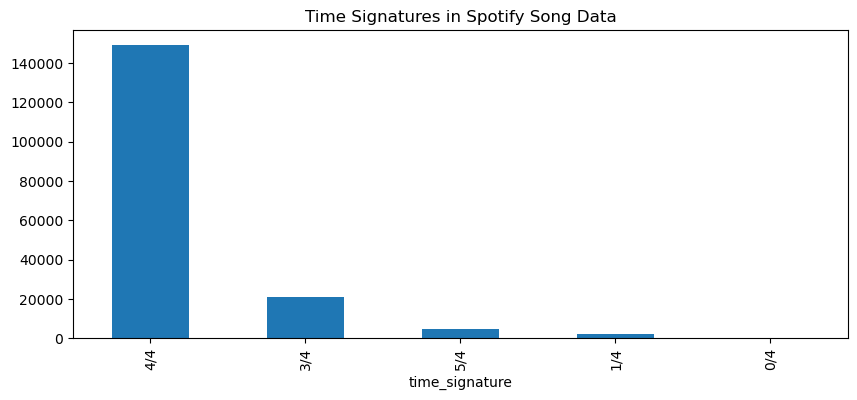

In [14]:
df['time_signature'].value_counts().plot(title='Time Signatures in Spotify Song Data', 
                                         kind='bar', figsize=(10, 4))

The time signature data is also unsurprising. To explain to non-musicians, 4/4 represents music where every fourth beat is emphasized--the classic rock hit *Carry On Wayward Son* by Kansas is an example. If you can count "one, two, three, four" along to the music and have it line up, it's probably 4/4. A lot of dance music is in 4/4, because humans have two feet, so of course it makes sense that we'd want to have that music organized around an even number, right?

Well, one well-known piece of music in 3/4 is also dance music: the Blue Danube Waltz by Johann Strauss! Though the tempo is a little flexible in that one, it's very easy to tell that its beats come in groups of three. A more modern example is *Piano Man* by Billy Joel. There's plenty of 3/4 music to go around, if not nearly as much as in 4/4.

5/4 music is a lot more difficult to write well, so it's not surprising that it's a distant third. As for 1/4 and 0/4, perhaps those are meant to represent tracks with no obvious meter: ambient noise, or spoken audio like podcasts. Then again, those don't show up in our `genre` column.

In [15]:
df[df['time_signature'] == '1/4']['genre'].value_counts()

genre
Comedy              541
Opera               334
Classical           284
Soundtrack          260
Movie               177
Anime                78
World                77
Folk                 74
Jazz                 71
Blues                66
Children's Music     66
Electronic           39
Soul                 33
Alternative          32
R&B                  29
Ska                  27
Hip-Hop              26
Country              23
Dance                22
Reggae               18
Reggaeton            14
Pop                  13
Indie                12
Rock                 11
Children’s Music      7
Rap                   6
A Capella             5
Name: count, dtype: int64

In any case, there's no immediately obvious pattern. Perhaps they're really missing data? Hard to say.

The remaining features are largely numerical, so rather than go through them one by one, we can do a correlation matrix to check all of them at once:

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176774 entries, 0 to 232724
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             176774 non-null  object 
 1   artist_name       176774 non-null  object 
 2   track_name        176773 non-null  object 
 3   track_id          176774 non-null  object 
 4   popularity        176774 non-null  int64  
 5   acousticness      176774 non-null  float64
 6   danceability      176774 non-null  float64
 7   duration_ms       176774 non-null  int64  
 8   energy            176774 non-null  float64
 9   instrumentalness  176774 non-null  float64
 10  key               176774 non-null  object 
 11  liveness          176774 non-null  float64
 12  loudness          176774 non-null  float64
 13  mode              176774 non-null  object 
 14  speechiness       176774 non-null  float64
 15  tempo             176774 non-null  float64
 16  time_signature    176774 

In [17]:
df_numeric = df.select_dtypes(include=['int64', 'float64'])

In [18]:
df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 176774 entries, 0 to 232724
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        176774 non-null  int64  
 1   acousticness      176774 non-null  float64
 2   danceability      176774 non-null  float64
 3   duration_ms       176774 non-null  int64  
 4   energy            176774 non-null  float64
 5   instrumentalness  176774 non-null  float64
 6   liveness          176774 non-null  float64
 7   loudness          176774 non-null  float64
 8   speechiness       176774 non-null  float64
 9   tempo             176774 non-null  float64
 10  valence           176774 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 16.2 MB


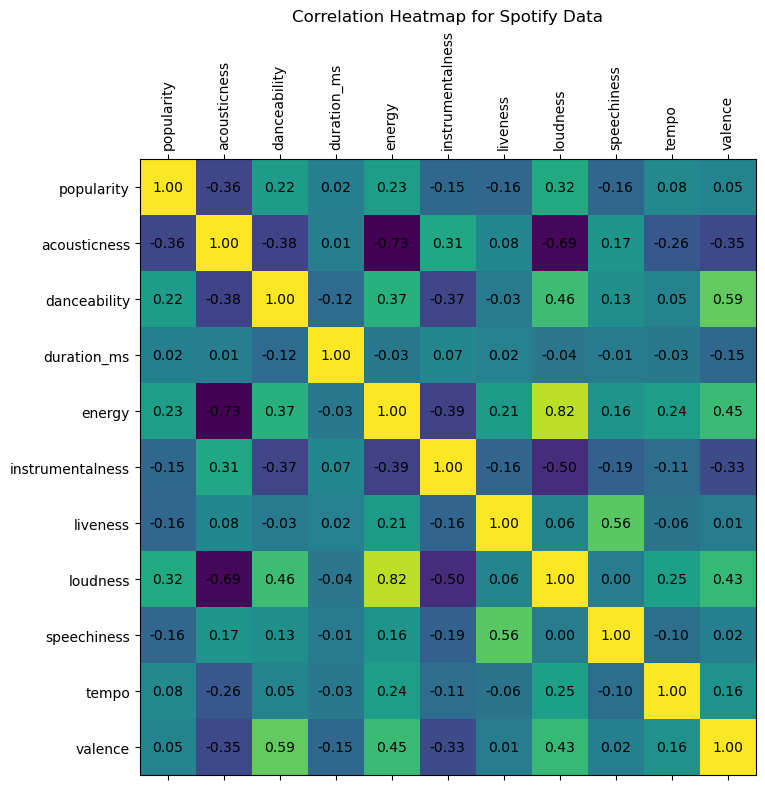

In [19]:
corr = df_numeric.corr()

fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90) # type: ignore
plt.yticks(range(len(corr.columns)), corr.columns) # type: ignore
plt.title("Correlation Heatmap for Spotify Data")

for i in range(len(corr.columns)):
    for j in range(len(corr.columns)):
        value = corr.iloc[i, j]
        if not None:
            plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')
plt.show()

We can see correlations with the whole dataset here, but for simplicity let's pare the chart down to just the popularity correlations:

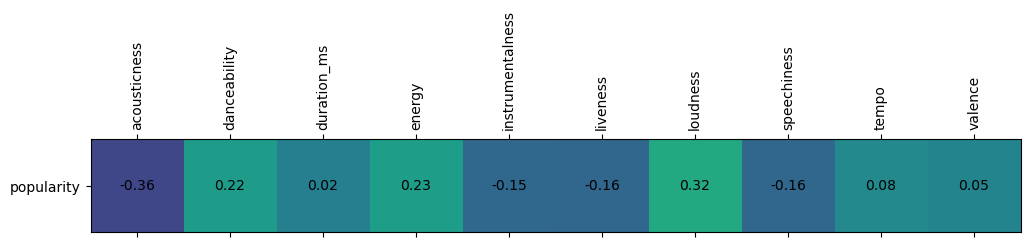

In [20]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(corr)
ax.set_xlim(0.5, len(corr.columns)-0.5)
ax.set_ylim(-0.5, 0.5)
plt.style.use('seaborn-v0_8-colorblind') #more legible colors
plt.xticks(range(1, len(corr.columns)), corr.columns[1:], rotation=90)
plt.yticks(range(0, 1), corr.columns[:1])

for i in range(0, 1):
    for j in range(1, len(corr.columns)):
        value = corr.iloc[i, j]
        if not None:
            plt.text(j, i, f"{value:.2f}", ha='center', va='center', color='black')
plt.show()

Highly popular music tends to be loud, energetic, and danceable, but not very acoustic. Live, speechy, and instrumental tracks also tend to not do as well. None of these correlations are incredibly strong, but perhaps our model will pick up on them anyway.

In [21]:
df.select_dtypes(include='number').info()

<class 'pandas.core.frame.DataFrame'>
Index: 176774 entries, 0 to 232724
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   popularity        176774 non-null  int64  
 1   acousticness      176774 non-null  float64
 2   danceability      176774 non-null  float64
 3   duration_ms       176774 non-null  int64  
 4   energy            176774 non-null  float64
 5   instrumentalness  176774 non-null  float64
 6   liveness          176774 non-null  float64
 7   loudness          176774 non-null  float64
 8   speechiness       176774 non-null  float64
 9   tempo             176774 non-null  float64
 10  valence           176774 non-null  float64
dtypes: float64(9), int64(2)
memory usage: 16.2 MB


In [22]:
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Index: 176774 entries, 0 to 232724
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   genre           176774 non-null  object
 1   artist_name     176774 non-null  object
 2   track_name      176773 non-null  object
 3   track_id        176774 non-null  object
 4   key             176774 non-null  object
 5   mode            176774 non-null  object
 6   time_signature  176774 non-null  object
dtypes: object(7)
memory usage: 10.8+ MB


### Preprocessing and "Sanity Checks"

There are two general parts of the data that need treatment separately: numerical and categorical data. The former will need standardized, so that features with wider ranges are not given overwhelming weight. The latter will need one-hot encoded so that it can be treated in the same fashion as numerical data.

In the course of making this document, I discovered that `duration_ms` contains massive mathematical outliers that actually throw off our training code. For that reason, we'll cut anything over ten minutes long, which is less than 1% of our data:

In [23]:
max_duration_ms = 10 * 60 * 1000
outlier_durations = df[df['duration_ms'] > max_duration_ms]
df.drop(outlier_durations.index, inplace=True)
df.describe()


,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000,174722.000000
mean,36.400774,0.400307,0.543295,227901.604280,0.559530,0.169063,0.223840,-10.062664,0.126428,117.365147,0.454159
std,17.389745,0.365098,0.189298,86630.935115,0.274724,0.320757,0.209927,6.351916,0.202227,31.326844,0.267183
min,0.000000,0.000000,0.057000,15387.000000,0.000020,0.000000,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,25.000000,0.044500,0.418000,177600.000000,0.349000,0.000000,0.097600,-12.713000,0.036800,92.043000,0.226000
50%,37.000000,0.282000,0.560000,218587.000000,0.595000,0.000065,0.130000,-8.138000,0.049500,115.049500,0.444000
75%,49.000000,0.784000,0.684000,266078.000000,0.790000,0.080300,0.276000,-5.609000,0.102000,139.007000,0.669000
max,100.000000,0.996000,0.989000,600000.000000,0.999000,0.999000,1.000000,3.744000,0.967000,242.903000,1.000000


There are a few categories I don't plan to train on, so let's drop those, then separate out the target column as well:

In [24]:
df.drop(['artist_name', 'track_name', 'track_id'], inplace=True, axis='columns')

features = df.drop('popularity', axis='columns')
target = df['popularity']
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174722 entries, 0 to 232724
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   genre             174722 non-null  object 
 1   acousticness      174722 non-null  float64
 2   danceability      174722 non-null  float64
 3   duration_ms       174722 non-null  int64  
 4   energy            174722 non-null  float64
 5   instrumentalness  174722 non-null  float64
 6   key               174722 non-null  object 
 7   liveness          174722 non-null  float64
 8   loudness          174722 non-null  float64
 9   mode              174722 non-null  object 
 10  speechiness       174722 non-null  float64
 11  tempo             174722 non-null  float64
 12  time_signature    174722 non-null  object 
 13  valence           174722 non-null  float64
dtypes: float64(9), int64(1), object(4)
memory usage: 20.0+ MB


One-hot encoding is generally done before the data is split into training and test sets, so:

In [25]:
features_numeric = features.select_dtypes(include='number')
features_string = features.select_dtypes(include='object')

features_string_ohe = pd.get_dummies(features_string, drop_first=True, dtype='int64')
# features_ohe = pd.merge(left=features.drop(features_string.columns, axis='columns'), right=features_string_ohe, how='outer', on=features.index)
features_ohe = features_string_ohe.join(features_numeric)

features_train, features_test, target_train, target_test = train_test_split(
    features_ohe, target, test_size = 0.2, random_state = 12345
)

One-hot encoding breaks out every category into a binary belongs-or-doesn't column of its own.

Standardization is slightly more complicated: it rescales the numerical features to have a mean of 0 and a standard deviation of 1. We can't do it prior to the train-test split, because that would be a case of data leakage: the test data would be affecting the training data directly, which defeats the purpose of keeping it separate in the first place. Instead we scale just on the training set:

In [26]:
# StandardScaler for numerical features
scaler = StandardScaler()

#get only the numeric features and only from what made it into the training set
features_numeric_train = features_train[features_numeric.columns]
scaler.fit(features_numeric_train)
# get the numeric features from the test set
features_numeric_test = features_test[features_numeric.columns]

# scale the training set
features_train[features_numeric_train.columns] = scaler.transform(features_numeric_train)
# scale the test set
features_test[features_numeric_test.columns] = scaler.transform(features_numeric_test)

We'll also want to have a scaled version of the target data. This will impact the neural network training later on. 

StandardScaler has a quirk: it doesn't work on one-dimensional data. So we use `reshape()` to convert it into a 2D array, then `flatten()` for later consumption by torch.

In [27]:
target_scaler = StandardScaler()
target_scaler.fit(target_train.values.reshape(-1,1))
target_train_scaled = target_scaler.transform(target_train.values.reshape(-1,1)).flatten()
target_test_scaled = target_scaler.transform(target_test.values.reshape(-1,1)).flatten()

In order to see how good our neural network will be, we need a base of comparison. A linear regression is a fast-to-calculate, relatively simple model.

Per the project instructions, our metric is Mean Squared Error (MSE). It's an average of the squares of the error of every prediction the model makes against the test features. This means (unlike Mean Absolute Error, which just uses absolute values of errors) that we'll treat large mistakes with extra severity when scoring the model.

However, MSE is a little difficult to interpret because the scale becomes pretty big. MAE, by comparison, just means "expect the model to be off by about this much on average". It's common to take the square root of MSE, which gives you a metric called Root Mean Squared Error (RMSE). This tends to be close to MAE, especially in cases where the model's error is low-variance. I've included it just for interpretability's sake.

Below we'll create a constant model, i.e. "just guess the mean every time," and a linear regression.

In [28]:
#constant model
const_pred = np.full(target_test.shape, fill_value=target_train.mean())
const_mse = mse(target_test, const_pred)
print('Constant model MSE: ', const_mse)
print('Constant model RMSE: ', const_mse ** 0.5)

#linear regression model
lreg = LinearRegression()
lreg.fit(features_train, target_train)
lreg_pred = lreg.predict(features_test)
lreg_mse = mse(target_test, lreg_pred)
print('Linear regression MSE: ', lreg_mse)
print('Linear regression RMSE: ', lreg_mse ** 0.5)

Constant model MSE:  302.333217364881
Constant model RMSE:  17.387731806215584
Linear regression MSE:  94.50829893871058
Linear regression RMSE:  9.721537889588795


So you can expect the linear regression's prediction to be within 9 or 10 points of the truth. Meanwhile, a constant model gets about a 17.4 RMSE for the same data. Can a neural network do better?

# Torch

PyTorch, or `torch`, is a framework for creating and training neural networks. Those are pretty computationally expensive, so one of the first things we'll do is check if a GPU is available:

In [29]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('CUDA-compatible device detected')
else: 
    device = torch.device('cpu')
print('Using: ', device)

CUDA-compatible device detected
Using:  cuda


Luckily we've got a CUDA-enabled device available.

For the neural network's input layer, we want one neuron for each feature. The output layer will be a single neuron, representing the target. 

We also are going to need to convert our DataFrames into tensors, which is the data format `torch` operates on. A tensor is effectively the same as a vector or matrix, in that it's a collection of numbers, but with an arbitrary amount of dimensions rather than one or two respectively.

In [30]:
feature_count = features_train.shape[1]
# convert data to pytorch tensors
features_train_tensor = torch.from_numpy(features_train.values).float().to(device)
features_test_tensor = torch.from_numpy(features_test.values).float().to(device)
target_train_tensor = torch.from_numpy(target_train_scaled).float().to(device)
target_test_tensor = torch.from_numpy(target_test_scaled).float().to(device)

print(feature_count)
print(target_train_tensor)

52


tensor([ 0.6090,  0.0340, -2.0937,  ...,  0.1490, -1.2886,  0.7240],
       device='cuda:0')


Following along with pytorch.org's tutorial, we create a NeuralNetwork class. After doing some reading on the subject, I decided to start by leaving the hidden layers of neurons the same size as the input layers.

In [31]:
# defining NeuralNetwork class as described in pytorch.org tutorial

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        activate = nn.SiLU
        dropout = 0.1
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(feature_count, feature_count // 2),
            activate(),
            nn.Dropout(dropout), #randomly sets % of neurons to zero--an anti-overfitting strategy
            nn.Linear(feature_count // 2, 1),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We'll instantiate a model, define our loss function, and define our optimizer. Adam is a fairly common optimizer for neural network applications.

We'll also store `n_iter` here, which (for now) will arbitrarily cap how many epochs we train the model for. We'll also set up a learning rate scheduler, which changes the learning rate of the neural network over time. This helps mitigate the drawbacks of both higher learning rates (large step size, unable to settle into optimal point easily) and lower learning rates (long convergence time, chance of finding local minima).

In [32]:
model = NeuralNetwork().to(device)
# def init_weights(m):
#     if isinstance(m, nn.Linear):
#         torch.nn.init.xavier_normal_(m.weight)
#         m.bias.data.fill_(0.01)

# model.apply(init_weights)

n_iter = 5000
loss_fn = nn.MSELoss()
learning_rate = 0.1
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.001)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 100, 1000], gamma=0.5)

In [33]:
print("Beginning training")
grad_norms = []
clip_threshold = None

lowest_loss_score = 10000
lowest_loss_val = 10000
lowest_loss_epoch = 0
lowest_loss_pred = None

for epoch in range(1, n_iter+1):
    model.train() # enables dropout if model.eval() is triggered
    optimizer.zero_grad()
    outputs = model(features_train_tensor)
    loss = loss_fn(outputs.squeeze(), target_train_tensor)    

    if (epoch % 100 == 0):
        model.eval()  # Set to evaluation mode (disables dropout)
        with torch.no_grad():  # Disable gradient computation
            val_outputs = model(features_test_tensor)
            val_loss = loss_fn(val_outputs.squeeze(), target_test_tensor)
            val_loss_value = val_loss.item()
        print(f'Epoch {epoch}\tTrain Loss: {train_loss_value}\tVal Loss:{val_loss_value}')

    #handle scheduler
    # old_lr = optimizer.param_groups[0]['lr']
    # scheduler.step()
    # new_lr = optimizer.param_groups[0]['lr']
    # if (new_lr != old_lr):
    #     print(f'Learning rate reduced from {old_lr} to {new_lr}')
        
    train_loss_value = loss.item()

    if (train_loss_value < lowest_loss_score):
        lowest_loss_epoch = epoch
        lowest_loss_score = train_loss_value
        # save predictions from this epoch
        model.eval()
        with torch.no_grad():  # Disable gradient computation
            val_outputs = model(features_test_tensor)
            val_loss = loss_fn(val_outputs.squeeze(), target_test_tensor)
            lowest_loss_val = val_loss.item()
            lowest_loss_test_pred = val_outputs

    
    loss.backward()
    # diagnose gradient explosion, which can cause sudden spikes in the loss function
    # grad_norm = nn.utils.clip_grad_norm_(model.parameters(), float('inf'))
    # if (epoch % 1000 == 0):
    #     print(f'Gradient norm at epoch {epoch}: ', {grad_norm})
    
    # # track recent gradient norms
    # grad_norms.append(grad_norm.item())
    # if (len(grad_norms) > 200):
    #     grad_norms.pop(0)

    # # gradient clipping based on above gradient norm measurements
    # if (epoch > 100):
    #     clip_threshold = np.median(grad_norms)
    #     # Always apply clipping
    #     nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_threshold)
    #     if (epoch % 1000 == 0):
    #         print(f'Clipping threshold currently: {clip_threshold}')

    optimizer.step()

print('Lowest loss epoch:\t', lowest_loss_epoch)
print('Lowest loss score:\t', lowest_loss_score)
print('V-loss for that epoch:\t', lowest_loss_val)

print('\nInitial learning rate:', learning_rate)
print('Final learning rate:', scheduler.get_last_lr()) # final learning rate if you're curious

Beginning training
Epoch 100	Train Loss: 0.3093250095844269	Val Loss:0.3062494993209839
Epoch 200	Train Loss: 0.303815096616745	Val Loss:0.3024671971797943
Epoch 300	Train Loss: 0.30244818329811096	Val Loss:0.3016595244407654
Epoch 400	Train Loss: 0.30088508129119873	Val Loss:0.3006478250026703
Epoch 500	Train Loss: 0.29985907673835754	Val Loss:0.3000281751155853
Epoch 600	Train Loss: 0.2998279929161072	Val Loss:0.2996629774570465
Epoch 700	Train Loss: 0.2988685369491577	Val Loss:0.2994619905948639
Epoch 800	Train Loss: 0.2994306981563568	Val Loss:0.2993578016757965
Epoch 900	Train Loss: 0.29785528779029846	Val Loss:0.29949015378952026
Epoch 1000	Train Loss: 0.29758894443511963	Val Loss:0.29936596751213074
Epoch 1100	Train Loss: 0.2976011335849762	Val Loss:0.29907551407814026
Epoch 1200	Train Loss: 0.30175256729125977	Val Loss:0.3008671998977661
Epoch 1300	Train Loss: 0.29990214109420776	Val Loss:0.3032956123352051
Epoch 1400	Train Loss: 0.29754719138145447	Val Loss:0.29883313179016113

We can see that the neural network makes pretty miniscule improvements after the first few hundred epochs. This was largely the trend even if it runs for tens of thousands of epochs: it's hard to do much better than we got around 200 epochs in. Since the validation score didn't start increasing noticeably, we didn't overfit, at least.

In [34]:
# Unscale predictions and get final score
predictions_scaled = model(features_test_tensor)
nn_pred = target_scaler.inverse_transform(predictions_scaled.cpu().detach().numpy())
mse_nn = mse(target_test, nn_pred)
print('\nFinal prediction unscaled results:')
print('Validation MSE: \t', mse_nn)
print('Validation RMSE:\t', mse_nn ** 0.5)

# Unscale predictions and get best score
nn_best_pred = target_scaler.inverse_transform(lowest_loss_test_pred.cpu().detach().numpy())
mse_nn_best = mse(target_test, nn_best_pred)
print('\nBest run prediction unscaled results:')
print('Validation MSE: \t', mse_nn_best)
print('Validation RMSE:\t', mse_nn_best ** 0.5)


Final prediction unscaled results:
Validation MSE: 	 90.33643312494088
Validation RMSE:	 9.504548023180318

Best run prediction unscaled results:
Validation MSE: 	 90.27101692401573
Validation RMSE:	 9.501106089504301


In [35]:
#rerunning for ease of access
#constant model
const_pred = np.full(target_test.shape, fill_value=target_train.mean())
const_mse = mse(target_test, const_pred)
print('Constant model MSE: ', const_mse)
print('Constant model RMSE: ', const_mse ** 0.5)

#linear regression model
lreg = LinearRegression()
lreg.fit(features_train, target_train)
lreg_pred = lreg.predict(features_test)
lreg_mse = mse(target_test, lreg_pred)
print('Linear regression MSE: ', lreg_mse)
print('Linear regression RMSE: ', lreg_mse ** 0.5)

Constant model MSE:  302.333217364881
Constant model RMSE:  17.387731806215584
Linear regression MSE:  94.50829893871058
Linear regression RMSE:  9.721537889588795


It's not by much, but we've managed to beat the linear regression! By turning the epochs even higher, we can achieve marginal additional gains, but it's likely not worthwhile.